# Data Analysis

## Imports and data formatting

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import pingouin as pg
from scipy import stats

In [2]:
# Colorblind-safe + grayscale-safe palette (Okabe–Ito)
COLORS = {
    "ai": "#0072B2",       # blue
    "natural": "#009E73",  # bluish green
    "cgi": "#D55E00"       # vermillion
}

TYPE_ORDER = ["natural", "cgi", "ai"]
PALETTE = [COLORS[t] for t in TYPE_ORDER]

MARKERS = {"ai": "o", "natural": "s", "cgi": "^"}
LINESTYLES = {"ai": "-", "natural": "--", "cgi": ":"}

### Survey

In [3]:
# -----------------------------------------------------------
# Load the CSV WITHOUT header
# -----------------------------------------------------------
df = pd.read_csv("QRD-survey - responses.csv", header=None)

# -----------------------------------------------------------
# 1. Add/rename headers: participant_id, image, rating
# -----------------------------------------------------------
df = df.rename(columns={
    0: "participant_id",
    1: "image",
    2: "rating"
})

# -----------------------------------------------------------
# 2. Identify valid participants: at least 54 entries
# -----------------------------------------------------------
counts = df["participant_id"].value_counts()
valid_ids = counts[counts >= 54].index

# Filter dataset to only include participants with >= 54
df = df[df["participant_id"].isin(valid_ids)]

# -----------------------------------------------------------
# 3. For participants with > 54 entries:
#    - Remove duplicates
#    - Ensure exactly 54 rows per participant
# -----------------------------------------------------------
cleaned_rows = []

for pid, group in df.groupby("participant_id"):
    # Remove duplicate rows (same image + rating)
    group = group.drop_duplicates(subset=["image", "rating"])

    # If less than 54 → participant should actually be discarded
    if len(group) == 54:
        cleaned_rows.append(group)

# Concatenate cleaned groups
df = pd.concat(cleaned_rows, ignore_index=True)

# -----------------------------------------------------------
# 4. Outlier detection on participants (BT.500-style)
#    - Compute mean rating for each participant
#    - Remove participants whose mean rating differs from
#      the global mean by more than 2 standard deviations
# -----------------------------------------------------------

# Mean rating per participant
subject_means = df.groupby("participant_id")["rating"].mean()

# Global mean and standard deviation of participant means
group_mean = subject_means.mean()
group_std = subject_means.std(ddof=1)

# Threshold (2 * standard deviation)
threshold = 2 * group_std

# IDs of outlier participants
outlier_ids = subject_means[(subject_means - group_mean).abs() > threshold].index

print(f"Detected {len(outlier_ids)} outlier participants (BT.500-style):")
print(list(outlier_ids))

# Remove outlier participants from the main dataframe
df = df[~df["participant_id"].isin(outlier_ids)].reset_index(drop=True)

# -----------------------------------------------------------
# 5. Preserve original order of participant_id appearance
#    (after outlier removal)
# -----------------------------------------------------------
valid_ids_list = list(dict.fromkeys(df["participant_id"]))

# -----------------------------------------------------------
# 6. Parse the image column (type_detail_number_factor.extension)
# -----------------------------------------------------------
df["image_no_ext"] = df["image"].str.replace(r"\.[^.]+$", "", regex=True)

df[["type", "detail", "number", "factor"]] = df["image_no_ext"].str.split("_", expand=True)

df["number"] = df["number"].astype(int)

df = df.drop(columns=["image_no_ext"])

# -----------------------------------------------------------
# Save final dataset
# -----------------------------------------------------------
df.to_csv("QRD-survey_cleaned.csv", index=False)

print("Processing complete. Saved as 'QRD-survey_cleaned.csv'.")

Detected 1 outlier participants (BT.500-style):
['f9a57916']
Processing complete. Saved as 'QRD-survey_cleaned.csv'.


In [4]:
df

,participant_id,image,rating,type,detail,number,factor
0,010495e7,natural_medium_2_x2.jpeg,3,natural,medium,2,x2
1,010495e7,cgi_low_1_x4.jpg,1,cgi,low,1,x4
2,010495e7,cgi_low_2_x2.jpg,4,cgi,low,2,x2
3,010495e7,natural_high_2_x2.jpeg,3,natural,high,2,x2
4,010495e7,natural_medium_1_x2.jpeg,3,natural,medium,1,x2
...,...,...,...,...,...,...,...
913,fcceea2c,ai_medium_1_x4.png,2,ai,medium,1,x4
914,fcceea2c,cgi_medium_2_x4.jpg,3,cgi,medium,2,x4
915,fcceea2c,natural_low_2_x2.jpg,2,natural,low,2,x2
916,fcceea2c,ai_low_1_x2.png,4,ai,low,1,x2


### Participants

In [5]:
# -----------------------------------------------------------
# Load CSV WITHOUT header
# -----------------------------------------------------------
df_participants = pd.read_csv("QRD-survey - participants.csv", header=None)

# -----------------------------------------------------------
# Add column headers
# -----------------------------------------------------------
df_participants.columns = [
    "participant_id",
    "age",
    "sex",
    "colorblindness",
    "expertise",
    "consent"
]

# -----------------------------------------------------------
# Convert age to integer (safe conversion)
# -----------------------------------------------------------
df_participants["age"] = pd.to_numeric(
    df_participants["age"],
    errors="coerce"   # invalid values become NaN
)

# Optional: drop rows with missing or invalid age
df_participants = df_participants.dropna(subset=["age"])

# Convert to int
df_participants["age"] = df_participants["age"].astype(int)

# -----------------------------------------------------------
# Keep only participants present in valid_ids_list
# -----------------------------------------------------------
df_participants = df_participants[
    df_participants["participant_id"].isin(valid_ids_list)
]

# -----------------------------------------------------------
# Save cleaned participants file
# -----------------------------------------------------------
df_participants.to_csv(
    "QRD-survey_participants_cleaned.csv",
    index=False
)

print("Participants file cleaned and saved as 'QRD-survey_participants_cleaned.csv'.")

Participants file cleaned and saved as 'QRD-survey_participants_cleaned.csv'.


In [6]:
# Number of participants and valid participant ids
print(f"Number of participants: {len(valid_ids_list)}")
print("Valid participant IDs:")
print(valid_ids_list)

Number of participants: 17
Valid participant IDs:
['010495e7', '0bb12f2a', '18de0593', '37dd76de', '40754341', '42e3ccfa', '462f6d13', '48a9b298', '6c3f54a4', '78d824fa', '8034b667', '86b9f945', 'bb25fa4c', 'c88e8dea', 'e5fe38db', 'f8ba384d', 'fcceea2c']


## Boxplots

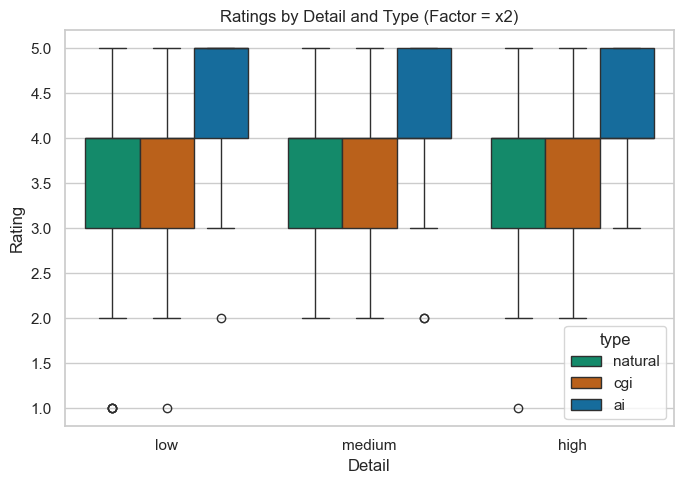

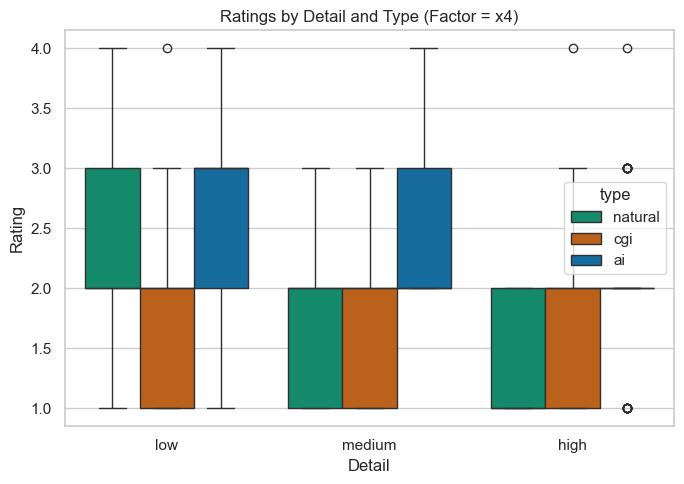

In [7]:
detail_order = ["low", "medium", "high"]

sns.set(style="whitegrid")
meanprops = {
    "color": "black",
    "linestyle": "--",
    "linewidth": 1
}

# -----------------------------------------------------------
# Boxplot for factor = x2
# -----------------------------------------------------------
df_x2 = df[df["factor"] == "x2"]

plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df_x2,
    x="detail",
    y="rating",
    hue="type",
    order=detail_order,
    hue_order=TYPE_ORDER,
    palette=PALETTE,
    meanline=True,
    meanprops=meanprops
)
plt.title("Ratings by Detail and Type (Factor = x2)")
plt.xlabel("Detail")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# Boxplot for factor = x4
# -----------------------------------------------------------
df_x4 = df[df["factor"] == "x4"]

plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df_x4,
    x="detail",
    y="rating",
    hue="type",
    order=detail_order,
    hue_order=TYPE_ORDER,
    palette=PALETTE,
    meanline=True,
    meanprops=meanprops
)
plt.title("Ratings by Detail and Type (Factor = x4)")
plt.xlabel("Detail")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

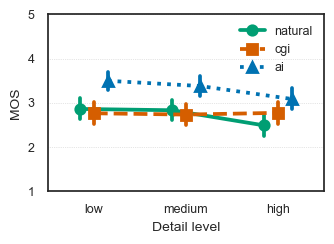

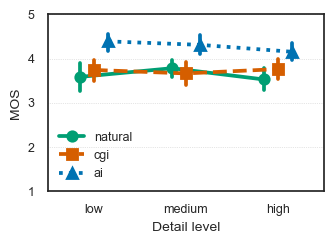

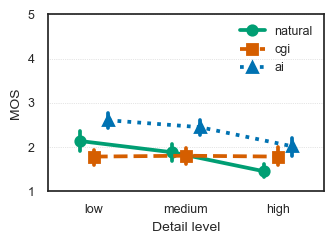

In [8]:
sns.set_style("white")

##### all plot #####
fig, ax = plt.subplots(figsize=(3.5, 2.6))

sns.pointplot(
    data=df,
    x="detail",
    y="rating",
    hue="type",
    order=["low", "medium", "high"],
    hue_order=TYPE_ORDER,
    palette=PALETTE,
    estimator=np.mean,
    errorbar=("ci", 95),
    dodge=0.3,
    markers=["o", "s", "^"],
    linestyles=["-", "--", ":"]
)

ax.set_xlabel("Detail level", fontsize=10)
ax.set_ylabel("MOS", fontsize=10)
ax.set_ylim(1, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.tick_params(labelsize=9)

ax.legend(frameon=False, fontsize=9)
ax.grid(axis="y", linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/detail-type-all.pdf")
plt.show()



##### x2 PLOT #####
df_x2 = df[df["factor"] == "x2"]
fig, ax = plt.subplots(figsize=(3.5, 2.6))

sns.pointplot(
    data=df_x2,
    x="detail",
    y="rating",
    hue="type",
    order=["low", "medium", "high"],
    hue_order=TYPE_ORDER,
    palette=PALETTE,
    estimator=np.mean,
    errorbar=("ci", 95),
    dodge=0.3,
    markers=["o", "s", "^"],
    linestyles=["-", "--", ":"]
)

ax.set_xlabel("Detail level", fontsize=10)
ax.set_ylabel("MOS", fontsize=10)
ax.set_ylim(1, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.tick_params(labelsize=9)

ax.legend(frameon=False, fontsize=9)
ax.grid(axis="y", linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/detail-type-x2.pdf")
plt.show()


##### x4 plot #####
df_x4 = df[df["factor"] == "x4"]
fig, ax = plt.subplots(figsize=(3.5, 2.6))

sns.pointplot(
    data=df_x4,
    x="detail",
    y="rating",
    hue="type",
    order=["low", "medium", "high"],
    hue_order=TYPE_ORDER,
    palette=PALETTE,
    estimator=np.mean,
    errorbar=("ci", 95),
    dodge=0.3,
    markers=["o", "s", "^"],
    linestyles=["-", "--", ":"]
)

ax.set_xlabel("Detail level", fontsize=10)
ax.set_ylabel("MOS", fontsize=10)
ax.set_ylim(1, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.tick_params(labelsize=9)

ax.legend(frameon=False, fontsize=9)
ax.grid(axis="y", linestyle=":", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/detail-type-x4.pdf")
plt.show()


## MOS per image

In [9]:
# ----------------------------
# 1) Load cleaned responses
# ----------------------------
clean_csv_path = "QRD-survey_cleaned.csv"  # <-- change this
df_clean = pd.read_csv(clean_csv_path)

# ----------------------------
# 2) Make sure rating is numeric
# ----------------------------
df_clean["rating"] = pd.to_numeric(df_clean["rating"], errors="coerce")
df_clean = df_clean.dropna(subset=["participant_id", "image", "rating"])

# (Optional) enforce consistent types
df_clean["participant_id"] = df_clean["participant_id"].astype(str)
df_clean["image"] = df_clean["image"].astype(str)

# ----------------------------
# 3) MOS per image (with stats)
# ----------------------------
mos_image = (
    df_clean
    .groupby(["image", "type", "detail", "number", "factor"])["rating"]
    .agg(MOS="mean", STD="std", N="count")
    .reset_index()
)

mos_image["CI95"] = 1.96 * mos_image["STD"] / np.sqrt(mos_image["N"])

print("\n=== MOS per image (first rows) ===")
print(mos_image.head())

# ----------------------------
# 4) MOS per condition (type × detail × factor)
#    (aggregates over 'number' and specific images)
# ----------------------------
mos_condition = (
    df_clean
    .groupby(["type", "detail", "factor"])["rating"]
    .agg(MOS="mean", STD="std", N="count")
    .reset_index()
)

mos_condition["CI95"] = 1.96 * mos_condition["STD"] / np.sqrt(mos_condition["N"])

print("\n=== MOS per condition (type, detail, factor) ===")
print(mos_condition.head())

# ----------------------------
# 5) Save outputs
# ----------------------------
mos_image.to_csv("mos_per_image.csv", index=False)
mos_condition.to_csv("mos_per_condition.csv", index=False)

print("\nSaved: mos_per_image.csv and mos_per_condition.csv")


=== MOS per image (first rows) ===
              image type detail  number factor       MOS       STD   N  \
0  ai_high_1_x2.png   ai   high       1     x2  4.176471  0.635934  17   
1  ai_high_1_x4.png   ai   high       1     x4  2.411765  0.712287  17   
2  ai_high_2_x2.png   ai   high       2     x2  4.000000  0.707107  17   
3  ai_high_2_x4.png   ai   high       2     x4  1.470588  0.514496  17   
4  ai_high_3_x2.png   ai   high       3     x2  4.294118  0.685994  17   

       CI95  
0  0.302304  
1  0.338600  
2  0.336137  
3  0.244576  
4  0.326101  

=== MOS per condition (type, detail, factor) ===
  type  detail factor       MOS       STD   N      CI95
0   ai    high     x2  4.156863  0.674464  51  0.185110
1   ai    high     x4  2.019608  0.734580  51  0.201609
2   ai     low     x2  4.392157  0.723282  51  0.198508
3   ai     low     x4  2.607843  0.634931  51  0.174260
4   ai  medium     x2  4.313725  0.787152  51  0.216038

Saved: mos_per_image.csv and mos_per_condition.c

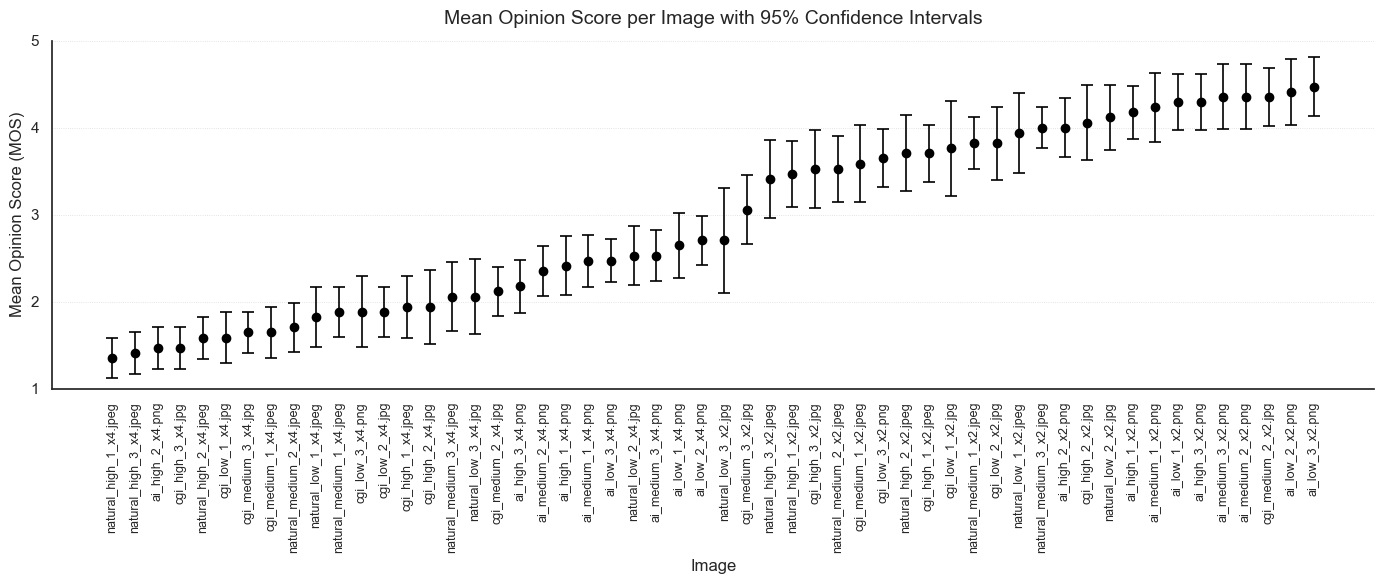

In [10]:
# Sort images by MOS
mos_sorted = mos_image.sort_values("MOS").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14, 6))  # bigger, standalone

# Error bar plot
ax.errorbar(
    x=range(len(mos_sorted)),
    y=mos_sorted["MOS"],
    yerr=mos_sorted["CI95"],
    fmt="o",
    markersize=6,
    capsize=4,
    capthick=1.2,
    elinewidth=1.2,
    color="black"
)

# X-axis formatting
ax.set_xticks(range(len(mos_sorted)))
ax.set_xticklabels(
    mos_sorted["image"],
    rotation=90,
    fontsize=9
)

# Y-axis formatting
ax.set_ylabel("Mean Opinion Score (MOS)", fontsize=12)
ax.set_xlabel("Image", fontsize=12)

ax.set_ylim(1, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.tick_params(axis="y", labelsize=11)

# Title (standalone-friendly)
ax.set_title(
    "Mean Opinion Score per Image with 95% Confidence Intervals",
    fontsize=14,
    pad=12
)

# Subtle grid (y only)
ax.grid(
    axis="y",
    linestyle=":",
    linewidth=0.6,
    alpha=0.7
)

# Clean spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("plots/mos-all.pdf")
plt.show()

## MOS difference computation

In [11]:
pivot = (
    mos_condition
    .pivot_table(
        index=["factor", "detail"],
        columns="type",
        values="MOS"
    )
    .reset_index()
)

# Compute differences relative to AI
pivot["AI_minus_CGI"] = pivot["ai"] - pivot["cgi"]
pivot["AI_minus_Natural"] = pivot["ai"] - pivot["natural"]

# Average over detail levels (low / medium / high)
mean_diff = (
    pivot
    .groupby("factor")[["AI_minus_CGI", "AI_minus_Natural"]]
    .mean()
    .reset_index()
)

# Compute overall mean across factors
overall_mean = (
    mean_diff[["AI_minus_CGI", "AI_minus_Natural"]]
    .mean()
    .to_frame()
    .T
)

overall_mean["factor"] = "Overall"

# Append to table
mean_diff_with_overall = pd.concat(
    [mean_diff, overall_mean],
    ignore_index=True
)

print("Mean MOS difference (averaged over detail levels)")
print(mean_diff_with_overall)

Mean MOS difference (averaged over detail levels)
type   factor  AI_minus_CGI  AI_minus_Natural
0          x2      0.562092          0.653595
1          x4      0.568627          0.535948
2     Overall      0.565359          0.594771


## Participants data

In [12]:
# -----------------------------------------------------------
# Helper function for counts + percentages
# -----------------------------------------------------------
def print_ratio(series, label):
    counts = series.value_counts()
    perc = series.value_counts(normalize=True) * 100

    parts = []
    for k in counts.index:
        parts.append(f"{k}: {counts[k]} ({perc[k]:.1f}%)")

    print(f"{label}: " + " | ".join(parts))


# -----------------------------------------------------------
# Age: mean ± std
# -----------------------------------------------------------
age_mean = df_participants["age"].mean()
age_std = df_participants["age"].std()

print(f"Age: {age_mean:.2f} ± {age_std:.2f}")


# -----------------------------------------------------------
# Sex
# -----------------------------------------------------------
print_ratio(df_participants["sex"], "Sex")


# -----------------------------------------------------------
# Expertise
# -----------------------------------------------------------
print_ratio(df_participants["expertise"], "Expertise")


# -----------------------------------------------------------
# Colorblindness
# -----------------------------------------------------------
print_ratio(df_participants["colorblindness"], "Colorblindness")

Age: 24.12 ± 3.64
Sex: Male: 13 (76.5%) | Female: 4 (23.5%)
Expertise: No: 10 (58.8%) | Yes: 7 (41.2%)
Colorblindness: No: 16 (94.1%) | Yes: 1 (5.9%)


### Statistical analysis

In [14]:
from statsmodels.formula.api import mixedlm

model = mixedlm(
    "rating ~ C(type) * C(detail) * C(factor)",
    data=df_clean,
    groups=df_clean["participant_id"]
)

result = model.fit(reml=False)
print(result.summary())

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               rating    
No. Observations:               918                   Method:                           ML        
No. Groups:                     17                    Scale:                            0.5015    
Min. group size:                54                    Log-Likelihood:                   -1006.0816
Max. group size:                54                    Converged:                        Yes       
Mean group size:                54.0                                                              
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [15]:
# Preparation dataset
mos_subject = (
    df
    .groupby(["participant_id", "type", "detail", "factor"], as_index=False)
    .agg(MOS=("rating", "mean"))
)

In [16]:
# Ensure categorical factors
mos_subject = mos_subject.copy()
mos_subject["participant_id"] = mos_subject["participant_id"].astype("category")
for c in ["type", "detail", "factor"]:
    mos_subject[c] = mos_subject[c].astype("category")

# Mixed effects model: fixed effects = type*detail*factor, random intercept per subject
model = smf.mixedlm(
    "MOS ~ type * detail * factor",
    data=mos_subject,
    groups=mos_subject["participant_id"]
).fit(reml=False)

print(model.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            MOS      
No. Observations:             306                Method:                        ML       
No. Groups:                   17                 Scale:                         0.1959   
Min. group size:              18                 Log-Likelihood:                -203.7195
Max. group size:              18                 Converged:                     Yes      
Mean group size:              18.0                                                       
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      4.157    0.130  32.034 0.000  3.903  4.411
type[T.cgi]                         

In [17]:
full = smf.mixedlm(
    "MOS ~ type * detail * factor",
    mos_subject,
    groups=mos_subject["participant_id"]
).fit(reml=False)

reduced = smf.mixedlm(
    "MOS ~ type * detail + type * factor + detail * factor",
    mos_subject,
    groups=mos_subject["participant_id"]
).fit(reml=False)

LR = 2 * (full.llf - reduced.llf)
df_diff = full.df_modelwc - reduced.df_modelwc
pval = stats.chi2.sf(LR, df_diff)

print("LRT type:detail:factor -> LR=", LR, "df=", df_diff, "p=", pval)

LRT type:detail:factor -> LR= 5.090003761270282 df= 4 p= 0.2781865936828583


### Post Hoc test

In [18]:
posthoc = pg.pairwise_tests(
    data=mos_subject,
    dv="MOS",
    within="type",
    subject="participant_id",
    padjust="holm",
    effsize="cohen"
)

posthoc_ai = posthoc[(posthoc["A"] == "ai") | (posthoc["B"] == "ai")]
print(posthoc_ai)

  Contrast   A        B  Paired  Parametric         T   dof alternative  \
0     type  ai      cgi    True        True  6.803961  16.0   two-sided   
1     type  ai  natural    True        True  8.460542  16.0   two-sided   

          p-unc        p-corr p-adjust      BF10     cohen  
0  4.235892e-06  8.471783e-06     holm  4799.389  1.567727  
1  2.662822e-07  7.988467e-07     holm  5.93e+04  1.538150  
